# Predicting Apartment Prices in Mexico City

## Importing the neceesary libraries  and files

In [ ]:
# Importing the neceesary libraries

from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

# Preparing data

In [ ]:
df = pd.read_csv ("mexico-city-real-estate-1.csv")
print("df shape", df.shape)
print("df description:\n", df["surface_covered_in_m2"].describe())
df.head()

df shape (4628, 16)
df description:
 count      4436.000000
mean        206.896979
std        1778.713741
min           0.000000
25%          67.000000
50%         100.000000
75%         205.000000
max      113100.000000
Name: surface_covered_in_m2, dtype: float64


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851852,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481481,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


In [ ]:
# Checking for null values
null_values = df.isnull().sum() / len(df) * 100
print ("Percentage of null values:", (null_values))

Percentage of null values: operation                      0.000000
property_type                  0.000000
place_with_parent_names        0.000000
lat-lon                       10.458081
price                          1.944685
currency                       1.944685
price_aprox_local_currency     1.944685
price_aprox_usd                1.944685
surface_total_in_m2           63.958513
surface_covered_in_m2          4.148660
price_usd_per_m2              75.151253
price_per_m2                   8.189283
floor                         93.712187
rooms                         97.061366
expenses                      99.891962
properati_url                  0.000000
dtype: float64


<Axes: >

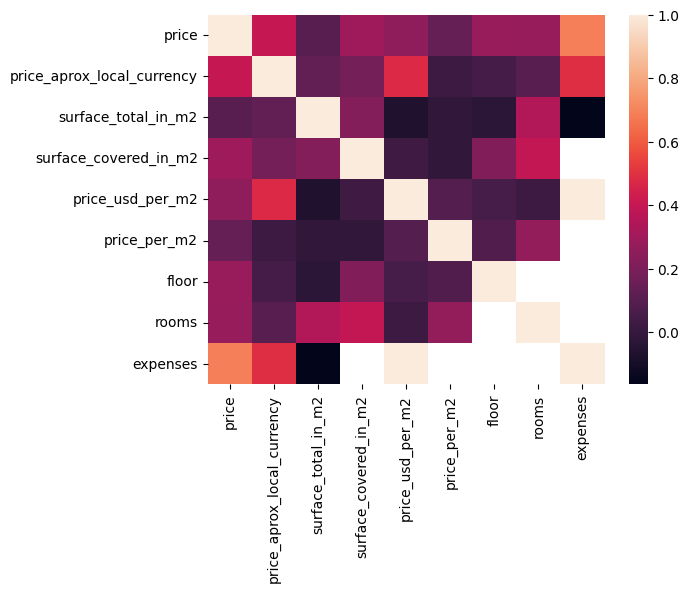

In [ ]:
#checking for correlation
correlation=df.select_dtypes('number').drop(columns="price_aprox_usd").corr()
sns.heatmap(correlation)

In [ ]:
# Building a `wrangle` function
def wrangle(filepath):
    #read csv file into dataframe
    df= pd.read_csv(filepath)

   #subset to properties in Distrito Federal
    mask_city = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"

    #subset to properties less than $100,000USD
    mask_price = df["price_aprox_usd"] < 100_000

    #subset
    df=df[mask_city & mask_price & mask_apt]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    #Split the "lat-lon" col
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get boroug place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)

    #Drop null col more than 50%
    df.drop(columns = [
        "surface_total_in_m2",
        "price_usd_per_m2",
        "floor",
        "rooms",
        "expenses"], inplace=True)

    # Drop low and high cardinality columns
    df.drop(columns = ['operation', 'property_type','currency', 'properati_url'], inplace = True)

    #Drop leaky columns
    df.drop(columns= ['price', 'price_aprox_local_currency','price_per_m2'],inplace=True)


    return df

In [ ]:
frame1 = wrangle ("mexico-city-real-estate-1.csv")
print("frame 1 shape", frame1.shape)
frame1.head()

frame 1 shape (1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [ ]:
# loading other csv files
files = sorted(glob("mexico-city-real-estate-*.csv"))
files

['mexico-city-real-estate-1.csv',
 'mexico-city-real-estate-2.csv',
 'mexico-city-real-estate-3.csv',
 'mexico-city-real-estate-4.csv',
 'mexico-city-real-estate-5.csv']

In [ ]:
# combining & cleaning all the datasets
df = pd.concat([wrangle(file)for file in files],ignore_index=True)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


## Explore

Text(0.5, 1.0, 'Distribution of Apartment Prices')

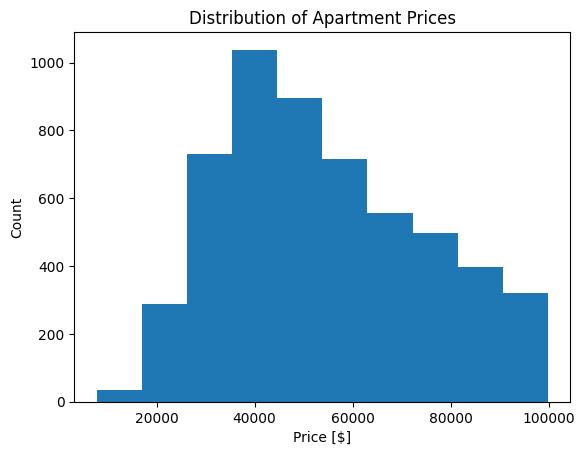

In [ ]:
# Hisrogram
fig, ax = plt.subplots()

# Plot the histogram on the axes object
ax.hist(df["price_aprox_usd"])

# Label axes using the axes
ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")


# Add title
ax.set_title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

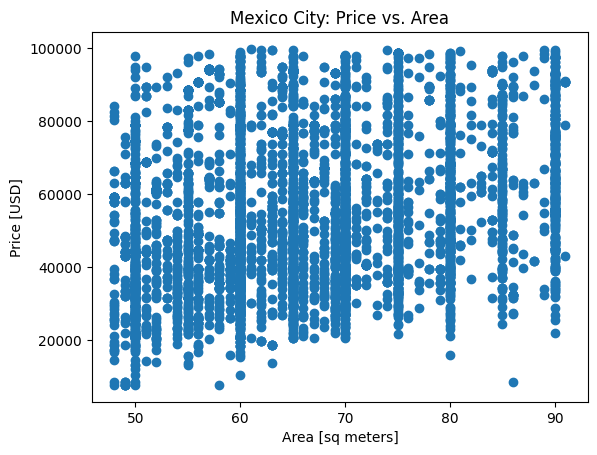

In [ ]:
fig, ax = plt.subplots()

# Create the scatter plot on the axes object
ax.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])

# Label axes
ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")

#  Add title
ax.set_title("Mexico City: Price vs. Area")

In [ ]:
# Plot Mapbox location and price

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
)
fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Data Split

In [ ]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2",	"lat", "lon", "borough"]
X_train = df[features]
y_train = df[target]

# Model Build

In [ ]:
# Base-line

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len (y_train)
baseline_mae = mean_absolute_error (y_train, y_pred_baseline)
print("Mean apt price:", round (y_mean, 2))
print("Baseline MAE:", round (baseline_mae, 2))


Mean apt price: 54246.53
Baseline MAE: 17239.94


In [ ]:
# Build Model
model = make_pipeline (
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

# Evaluate

In [ ]:
X_test = pd.read_csv("mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


In [ ]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

,0
0,53538.366480
1,53171.988369
2,34263.884179
3,53488.425607
4,68738.924884


# Communicate Result

In [ ]:
coefficients = model.named_steps['ridge'].coef_
features_names = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features_names)

#sorted ascending by absolute value.
feat_imp = feat_imp.reindex(feat_imp.abs().sort_values().index)
feat_imp

/tmp/ipython-input-4070345015.py:2: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



,0
surface_covered_in_m2,291.654156
borough_Cuauhtémoc,-350.531990
borough_Iztacalco,405.403127
lat,478.901375
borough_Xochimilco,929.857400
borough_Miguel Hidalgo,1977.314718
borough_Azcapotzalco,2459.288646
lon,-2492.221814
borough_Álvaro Obregón,3275.121061
borough_Coyoacán,3737.561001


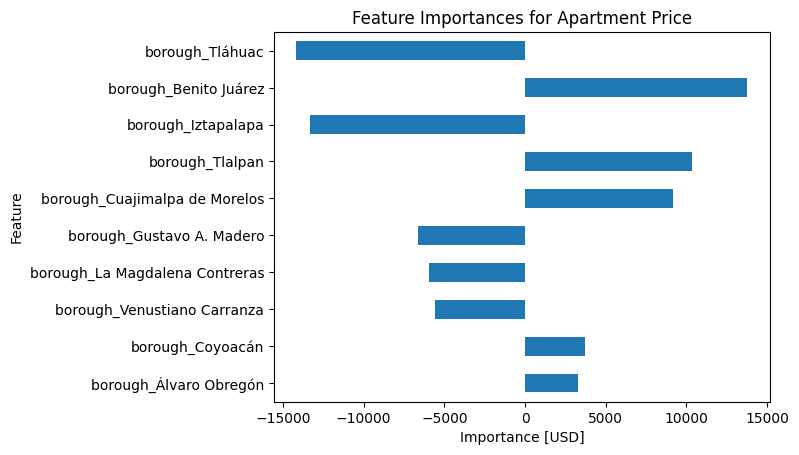

In [ ]:
fig, ax = plt.subplots()

# Select top 10 most important coefficients by absolute value
top10 = feat_imp.reindex(feat_imp.abs().sort_values(ascending=False).head(10).index)

# Create the horizontal bar plot
top10.plot(kind="barh", ax=ax)

# Label axes
ax.set_xlabel("Importance [USD]")
ax.set_ylabel("Feature")

# Add title
ax.set_title("Feature Importances for Apartment Price")

# Put the most important at the top
ax.invert_yaxis()

## Building Interactive Dashboard



In [ ]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index=[0])
    prediction= model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [ ]:
make_prediction(110, -34.60, -58.46, "Cuauhtémoc")

'Predicted apartment price: $-62141.51'

In [ ]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…